# Project Report: AIF Project

## Introduction
    
The AIF project, hosted on [GitHub](https://github.com/filippo-baglini/aif-project), aims to develop an intelligent agent for the MiniGrid environment, a highly customizable discrete-action environment within the Gymnasium library. 

Gymnasium is a Python framework designed for creating and testing simulated environments for reinforcement learning, offering a variety of pre-made scenarios for developing and benchmarking AI algorithms. MiniGrid, one of these environments, features a grid-based layout where the agent, represented as a triangle, interacts with objects like doors, keys, and boxes to navigate various challenges. 
Its high degree of configurability makes it an ideal platform for AI experimentation and customization.
    
The AIF Project aims to develop a custom AI agent for the MiniGrid environment, focusing specifically on a subset of scenarios known as BabyAI levels. BabyAI, a predecessor of the current MiniGrid library, features static, non-resetting obstacles that provide a simpler and more controlled framework for evaluating and training agents on grid-world tasks. This reduced complexity makes BabyAI levels particularly well-suited for designing and testing a custom utility-based agent. The project seeks to demonstrate the agent's capabilities by competing against an existing AI agent developed by the creators of the MiniGrid library, showcasing its efficiency and effectiveness in solving BabyAI tasks.
    

## Methodology
This project leverages Python and various AI algorithms to interact with the BabyAI environment. The primary objective is to develop a general-purpose agent capable of solving all 92 tasks provided by the BabyAI library. Additionally, the project emphasizes optimizing the agent's performance by implementing strategies and custom heuristics designed to minimize the number of steps needed to complete each task, ensuring both efficiency and effectiveness across all challenges.


### Needed to overcome the Key challenges include:

1. **Limited Observability**
    - The agent's restricted field of view provides incomplete information about the goal location
3. **Efficient Navigation**
    - Custom algorithms and heuristics ensure the agent moves efficiently through the environment
5. **Dynamic Planning**
    - The agent must plan online to handle subgoals and avoid getting stuck or hidden while reaching the main goal
7. **Multiple Mission Handling**
    - Tasks often involve multiple goals within a single mission



## Initial Approach

We initially focused on tackling simpler environments by first ensuring the agent could successfully complete them in any amount of steps and then gradually optimizing its actions to minimize the number of steps required.

### Performance Metric
But what exactly is defined as a *step* for our agent?
A step represents an individual action taken by the agent, such as:
- Moving forward to the next cell.
- Rotating to change direction.
- Picking up an object.

Each step carries a cost, presenting the challenge of planning every action carefully to maximize efficiency.
### Basic Strategy and Algorithms
To handle simpler levels, we implemented the following approach:

1. **Internal State Representation**  
   - The agent maintains an internal map of what it has seen and remembers previously observed areas. This internal state allows the agent to track its surroundings effectively.
2. **Exploration Strategy**
   - The agent performs a visual scan of its current field of view to locate the target specified in the mission.
   - If the target is not visible, the agent moves toward a **frontier cell** a cell located at the edge of the currently explored map.  
   - The frontier cell is selected using a custom Manhattan distance heuristic that penalizes frontiers blocked by obstacles such as doors or walls. This ensures the agent selects a strategic frontier, minimizing wasted steps while exploring new areas.  
3. **Pathfinding with A\* and Manhattan Distance**  
   - If the target has been identified, or we choose to move to a frontier cell the agent uses the A\* search algorithm to compute the optimal path, utilizing the Manhattan heuristic to estimate distances.  
   - Obstacles such as closed doors, lava tiles, and walls are considered during path computation to ensure safe and efficient navigation.


By combining these strategies, the agent is able to handle simple environments effectively and efficiently.




In [1]:
def a_star_search(self, target):
        """
        A* search algorithm for a grid.
        
        grid: 2D list representing the environment (0: free space, 1: obstacle).
        start: Tuple (x, y) for the start position.
        goal: Tuple (x, y) for the goal position.
        
        Returns the best path as a list of (x, y) tuples or None if no path exists.
        """

        # Priority queue for open set
        open_set = []
        heapq.heappush(open_set, (0, self.pos))  # (f-score, cell)

        # g-scores (costs to reach each cell)
        g_score = {self.pos: 0}
        f_score = {self.pos: manhattan_distance(self.pos, target)}
        # Path tracking
        came_from = {}

        while open_set:
            
            # Pop the cell with the lowest f-score
            _, current = heapq.heappop(open_set)

            # Goal reached
            if current == target:
                # Reconstruct path
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                return path[::-1]  # Reverse the path

            # Explore neighbors
            for neighbor in self.neighbors(current):

                if (self.vis_obs[neighbor[0], neighbor[1]][0] in (2, 9) or (self.vis_obs[neighbor[0], neighbor[1]][0] == 0 and neighbor != target)):
                    continue
                
                else:
                    # Check if a better direction is already faced (this is where your rotation logic applies)
                    direction_to_cell = (neighbor[0] - current[0], neighbor[1] - current[1])
                    if np.array_equal(direction_to_cell, np.array(self.f_vec)):
                        if(self.vis_obs[neighbor[0], neighbor[1]][0] in (5, 6, 7)):
                            if self.carrying:
                                tentative_g = g_score[current] + 5 #Rotate, drop the carried item, rotate, pick up, move forward
                            else:
                                tentative_g = g_score[current] + 2 #Pick up the item and then move forward
                        else:
                        # No rotation needed, just moving forward
                            tentative_g = g_score[current] + 1  # Moving forward
                    elif np.array_equal(direction_to_cell, -np.array(self.f_vec)):
                        if(self.vis_obs[neighbor[0], neighbor[1]][0] in (5, 6, 7)):
                            if self.carrying:
                                tentative_g = g_score[current] + 7
                            else:  
                                tentative_g = g_score[current] + 4
                        #cell behind us, 2 rotaton and 1 forward
                        else:
                            tentative_g =  g_score[current] + 3
                    else:
                        if(self.vis_obs[neighbor[0], neighbor[1]][0] in (5, 6, 7)):
                            if self.carrying:
                                tentative_g = g_score[current] + 6
                            else:
                                tentative_g = g_score[current] + 3
                        # Rotation + move forward (rotate 90 degrees)
                        else:
                            tentative_g = g_score[current] + 2  # Rotate and move

                    if neighbor not in g_score or tentative_g < g_score[neighbor]:
                        # Update g-score and f-score
                        g_score[neighbor] = tentative_g
                        f_score = tentative_g + manhattan_distance(neighbor, target)
                        heapq.heappush(open_set, (f_score, neighbor))
                        came_from[neighbor] = current

        # No path found
        print("Path not found")
        return "FAILURE"

## More Complex levels

As the complexity of the enviorment increased, the agent had to navigate environments with additional challenges, such as locked doors, keys, and other obstacles. To address these complexities, we developed a **subgoal-based system** to enable dynamic online planning.

### Subgoal System and Online Planning

1. **Subgoal Identification**  
   - For missions requiring multiple objectives (e.g., collecting a key and opening a door), the agent dynamically identifies subgoals based on the mission's requirements
   - Subgoals are stored in the agent's memory until they are successfully completed

2. **Online Planning**  
   - The agent evaluates its current state and updates its plan in real time as new information is discovered, such as the location of a key or an unopened door
   - This adaptive planning helps avoid deadlocks and ensures progress even in previously unseen or obstructed areas

3. **Obstacle Handling**  
   - Obstacles like locked doors are integrated online into the agent's internal map, in case they are necessary to proceed in completing current subgoal
   - The agent evaluates complex scenarios and intelligently initializes a sequence of subgoals required to overcome these obstacles, ensuring progress toward the main subgoal

4. **Inventory limit handling**  
   - The agent's inventory is restricted to holding only one item. In certain levels, the agent must navigate confined environments with numerous obstacles while carrying a crucial object required to complete the main subgoal. This limitation compels the agent to dynamically create and prioritize multiple secondary subgoals, ensuring it can temporarily drop the item, clear the initial path, and retrieve it later to complete the mission successfully

By introducing this subgoal-based online planning system, the agent can effectively tackle more complex environments, systematically addressing challenges and maintaining efficiency while solving tasks with multiple objectives.


In [2]:
class Subgoal:
    def __init__(self, planner):
        self.planner = planner

    def __call__(self):
        raise NotImplementedError

class GoNextToSubgoal(Subgoal): #This class is used to move the agent to a target position and the reason dictates how the agent will behave when it reaches the target
    def __init__(self, planner, target, reason="GoNextTo", target_pos=None):
        super().__init__(planner)
        self.target = target
        self.reason = reason
        self.target_pos = target_pos

        self.action = None

    def __call__(self):
        
        self.action = None

        if self.target_pos is None: #If target position is not defined we request ExploreSubgoal to handle what target position to consider
            self.planner.sub_goals.insert(0, ExploreSubgoal(self.planner, self.target, self.reason))
            return self.planner.actions.done
        
        if self.reason == "Explore": #Continous scan for target even during exploration towards frontier to not waste steps if target is found
            if self.planner.look_for_goal(self.target[0], self.target[1], self.target[2]) != None:
                self.planner.prev_frontier = None
                self.action = self.planner.actions.done
            if self.planner.vis_mask[self.target_pos]:
                self.action = self.planner.actions.done
         
        if self.reason == "PutNext": 
            if self.target[0] != 4:
                prova_target = self.planner.look_for_goal(self.target[0], self.target[1], self.target[2])
                neighbors = self.planner.neighbors(prova_target)
                if (self.target not in neighbors):
                    target = self.planner.find_closest_drop_cell(prova_target)
                    self.target_pos = target

        neighbors = self.planner.neighbors(self.target_pos)
        if self.reason == "Open":
            if self.planner.vis_obs[self.target_pos][2] == 2 or any(self.planner.vis_obs[n[0], n[1]][2] == 2 for n in neighbors): #Check if door we are supposed to open is locked
                if self.planner.vis_obs[self.target_pos][2] == 2:
                    color=self.planner.vis_obs[self.target_pos][1]
                else:
                    for n in neighbors:
                        if self.planner.vis_obs[n[0], n[1]][2] == 2:
                            color = self.planner.vis_obs[n][1]
                if self.planner.carrying_object is not None: #Check if carrying object 

                    if self.planner.carrying_object[1] != color or self.planner.carrying_object[0] != 5: #Check if carrying object is not key we need
                        self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, [5,color,None], "PickUp_Keep_important")) #If not key we need we init a new subgoal to pick up the key

                        return self.planner.actions.done
                    
                else:
                    self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, [5,color,None], "PickUp_Keep_important")) #If not carrying object we init a new subgoal to pick up the key

                    return self.planner.actions.done
                
        if self.action is None:
            self.action = self.planner.move_to_target(self.target_pos) #We call function to move towards target position

        if self.action == "FAILURE": #If we get a failure we interrupt bot and stop environment
            return "FAILURE"

        if self.action == "BLOCKED": #Handles blocked frontal path

            if self.planner.carrying: #Check if we are carrying 
                empty_cell = self.planner.find_closest_empty_cell(self.planner.pos)

                if self.planner.carrying_target in self.planner.important_objects: #Check if we are carrying important object for next subgoal

                    self.planner.save_path = self.planner.path #Save the current path we were following
                    
                    #Init subgoal where we drop important object and save coords
                    #Init subgoal to pick up and move blocking object
                    #Init subgoal to to return to dropped important item and pick it up again
                    self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.planner.carrying_target, "PickUp_Keep_important"))
                    self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.planner.target_in_cell(self.planner.path[0], self.target), "PickUp_NoKeep_Move", self.planner.cell_in_front()))
                    self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.planner.carrying_target, "Drop_important", empty_cell))
                    
                else:
                    if self.reason == "Drop": #Check if item was supposed to be dropped somewhere specific

                        self.planner.save_path.extend(self.planner.path) #Extends the current path with the new path for dropping item

                        #Init subgoal where we drop object temporarily
                        #Init subgoal to pick up and move blocking object
                        #Init subgoal to to return to dropped item and pick it up again
                        self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.planner.carrying_target, "PickUp_Keep"))
                        self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.planner.target_in_cell(self.planner.path[0], self.target), "PickUp_NoKeep_Move", self.planner.cell_in_front()))
                        self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.planner.carrying_target, "Drop", empty_cell))
                        
                    else:
                        self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.target, "Drop", empty_cell))

            else:
                #If not carrying we init a new subgoal to pick up the object blocking our path
                self.planner.sub_goals.insert(0, PickupSubgoal(self.planner, self.target))

            return self.planner.actions.done
        
        if self.action == "BLOCKED_SIDE": #Handles blocked side path and we are carrying object

            empty_cell = self.planner.find_closest_empty_cell(self.planner.pos)

            if self.planner.carrying_target in self.planner.important_objects: #Check if we are carrying important object for next subgoal
   
                self.planner.save_path = self.planner.path #Save the current path we were following

                #Init subgoal where we drop important object and save coords
                #Init subgoal to pick up and move blocking object
                #Init subgoal to to return to dropped important item and pick it up again
                self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.planner.carrying_target, "PickUp_Keep_important"))
                self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.planner.target_in_cell(self.planner.path[0], self.target), "PickUp_NoKeep_Move", self.planner.path[0]))
                self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.planner.carrying_target, "Drop_important", empty_cell))

            else:
                if self.reason == "Drop": #Check if item was supposed to be dropped somewhere specific
                    
                    self.planner.save_path.extend(self.planner.path)

                    #Init subgoal where we drop object temporarily
                    #Init subgoal to pick up and move blocking object
                    #Init subgoal to to return to dropped item and pick it up again
                    self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.planner.carrying_target, "PickUp_Keep"))
                    self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.planner.target_in_cell(self.planner.path[0], self.target), "PickUp_NoKeep_Move", self.planner.path[0]))
                    self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.planner.carrying_target, "Drop", empty_cell))

                else:
                    #If carrying useless object we init a new subgoal to drop it
                    self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.target, "Drop", empty_cell))

            return self.planner.actions.done 

        if self.action == "OPEN DOOR": #Handles open door subgoal
            self.planner.sub_goals.insert(0, OpenSubgoal(self.planner))

            return self.planner.actions.done
        
        if self.action == self.planner.actions.done: #If we reached target position we handle the reason for the subgoal
            self.planner.sub_goals.pop(0)

            if self.reason == "PickUp_Keep":
                self.planner.sub_goals.insert(0, PickupSubgoal(self.planner, self.target))

            elif self.reason == "PickUp_NoKeep": 
                self.planner.sub_goals.insert(0, DropSubgoal(self.planner))
                self.planner.sub_goals.insert(0, PickupSubgoal(self.planner, self.target))

            elif self.reason == "PickUp_NoKeep_Move": 
                empty_cell = self.planner.find_closest_empty_cell_avoiding_previous_path(self.planner.cell_in_front())
                #We call avoid path funtion since we typically move the object to not block the path we need to bring another object through
                self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.target, "Drop", empty_cell))
                self.planner.sub_goals.insert(0, PickupSubgoal(self.planner, self.target))

            elif self.reason == "PickUp_Keep_important": 
                self.planner.sub_goals.insert(0, PickupSubgoal(self.planner, self.target))

                if self.target not in self.planner.important_objects:
                    self.planner.important_objects.append(self.target)

            elif self.reason == "Drop_important":
                self.planner.sub_goals.insert(0, DropSubgoal(self.planner))
                self.planner.important_objects_coords.append(self.planner.cell_in_front())
                
            elif self.reason == "PutNext":
                self.planner.important_objects.remove(self.planner.carrying_target) 
                self.planner.sub_goals.insert(0, DropSubgoal(self.planner))

            elif self.reason == "Open":
                self.planner.sub_goals.insert(0, OpenSubgoal(self.planner))

            elif self.reason == "Drop":
                self.planner.sub_goals.insert(0, DropSubgoal(self.planner))

        return self.action
            

class OpenSubgoal(Subgoal):
    def __init__(self, planner):
        super().__init__(planner)
        
    def __call__(self):
        if (self.planner.vis_obs[self.planner.cell_in_front()][2] == 0): #Handles opening an already opened door
            action = self.planner.actions.toggle           
        else:
            action = self.planner.actions.toggle
            self.planner.sub_goals.pop(0)
            
        return action    
    
    
class PickupSubgoal(Subgoal):
    def __init__(self, planner, target, reason = "PickUp_Keep"):
        super().__init__(planner)
        self.target = target
        self.reason  = reason

    def __call__(self):
        if self.planner.carrying: #Handles the case where the agent is already carrying an object

            self.planner.sub_goals.pop(0)
            
            empty_cell = self.planner.find_closest_empty_cell(self.planner.pos)
            
            #Init subgoal to drop object
            #Init subgoal where we pass reason for picking up object
            self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.target, self.reason))
            self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, None, "Drop", empty_cell))
            return self.planner.actions.done
        
        action = self.planner.actions.pickup
        self.planner.carrying = True
        self.planner.carrying_target = self.target
        self.planner.carrying_object = self.planner.vis_obs[self.planner.cell_in_front()]

        self.planner.sub_goals.pop(0)

        return action


class DropSubgoal(Subgoal):
    def __init__(self, planner):
        super().__init__(planner)

    def __call__(self):

        action = self.planner.actions.drop
        self.planner.sub_goals.pop(0)

        self.planner.carrying = False
        self.planner.carrying_object = None
        self.planner.carrying_target = None

        return action
    

class ExploreSubgoal(Subgoal):
    def __init__(self, planner, target, reason="GoNextTo"):
        super().__init__(planner)

        self.target = target
        self.target_pos = None
        self.reason = reason

        self.frontier = None
        self.sub_goal_complete = False
        self.action = None

    def __call__(self):
        self.target_pos = self.planner.look_for_goal(self.target[0], self.target[1], self.target[2]) #Look for target position

        if self.target_pos is None: #Target isnt found we look for a frontier

            self.frontier = self.planner.find_frontiers() 

            if self.frontier == self.planner.prev_frontier: #Avoids getting stuck in a loop calling the same frontier
                self.frontier = self.planner.find_new_frontiers(self.frontier)

            if self.frontier is None: #If no frontier is found we interrupt bot and stop environment
                return "FAILURE"

            neighbors = self.planner.neighbors(self.frontier)
         
            if any(self.planner.vis_obs[n[0], n[1]][2] == 2 for n in neighbors): #Check if frontier is behind a locked door
                for n in neighbors:
                    if self.planner.vis_obs[n[0], n[1]][2] == 2:
                        target = n
                self.planner.sub_goals.pop(0)
                self.planner.prev_frontier = self.frontier

                #Init subgoal to open door and eventually look for key
                self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.planner.door_in_cell(target), "Open", target))
            
            else:
                self.planner.sub_goals.pop(0)
                self.planner.prev_frontier = self.frontier

                #Init subgoal to move towards frontier
                self.planner.sub_goals.insert(0, GoNextToSubgoal(self.planner, self.target, "Explore", self.frontier))

            return self.planner.actions.done
        
        else:

            self.planner.sub_goals.pop(0)

            
            if self.reason == "PutNext":

                #If we are supposed to put object next to target we find closest empty cell and consider it as target position
                self.target_pos = self.planner.find_closest_drop_cell(self.target_pos)
                self.planner.drop_pos = self.target_pos
                self.planner.sub_goals[0].target_pos = self.target_pos

            else:

                #If target is found we move towards target position
                self.planner.sub_goals[0].target_pos = self.target_pos

            return self.planner.actions.done

## Our Agent vs BabyAI

BabyAI is an intelligent agent implemented in the Minigrid libraries. It uses the "Breath Deep Search" to search the best path and the Manhattan distance to measure the step needed to reach the goal.

We evaluated the performance of our agent against BabyAI by testing their ability to solve the environments provided by MiniGrid. The primary metric for comparison was the number of steps required to complete each task. The evaluation was conducted across 100 different seeds, with each seed encompassing all 92 BabyAI environments. Room layouts and obstacle placements were randomized for each run, and in some cases, the goal itself was altered, selected from a predefined pool of possible missions.

Here our performance confronted with BabyAI:


In [3]:
# Install the required libraries   
!pip install git+https://github.com/filippo-baglini/aif-project.git


  Cloning https://github.com/filippo-baglini/aif-project.git to /tmp/pip-req-build-7iy16cl3
  Running command git clone --filter=blob:none --quiet https://github.com/filippo-baglini/aif-project.git /tmp/pip-req-build-7iy16cl3
  Resolved https://github.com/filippo-baglini/aif-project.git to commit bacab72da360aea2d987d7673b7ce16da06d19f9
done build dependencies ... 
doneGetting requirements to build wheel ... 
donePreparing metadata (pyproject.toml) ... 


In [4]:
!pip install matplotlib

In [5]:
import importlib.resources
from IPython.display import display, HTML

# Load the text file from the package
def load_and_display_file():
    # Use `files` to locate the package resource
    file_path = importlib.resources.files("aif_project.results") / "comparison_results_with_means.txt"
    with file_path.open("r") as file:
        contents = file.read()

    # Display the contents in the notebook
    display(HTML(f"<pre>{contents}</pre>"))

# Call the function
load_and_display_file()


## Demonstration
The following code demonstrates the execution of 3 levels contained in the BabyAI enviroment tests between seed 0 and 99.


In [6]:
import gymnasium as gym
from minigrid.envs.babyai.core.verifier import *

from aif_project.src.bot import Bot
from aif_project.src.goal_parser import *

import time
import random

broken_bonus_envs = {
    "BabyAI-PutNextS5N2Carrying-v0",
    "BabyAI-PutNextS6N3Carrying-v0",
    "BabyAI-PutNextS7N4Carrying-v0",
    "BabyAI-KeyInBox-v0",
}

# get all babyai envs (except the broken ones)
babyai_envs = []
for k_i in gym.envs.registry.keys():
    if k_i.split("-")[0] == "BabyAI":
        if k_i not in broken_bonus_envs:
            babyai_envs.append(k_i)

reward_list = []

print("----------------------------------------")

for i in range(0,1):

    random_env = random.randint(0, len(babyai_envs)-1)
    random_seed = random.randint(0, 100)

    env_id = babyai_envs[random_env] # Loop through all environments

    env = gym.make(env_id, render_mode ="human", agent_pov = False) 

    env.reset(seed=random_seed)

    print(f"Testing environment: {env_id}")
    print(f"Mission: {env.unwrapped.mission}") 

    bot = Bot(env)
    max_steps = 500
    num_steps = 0

    for i in range (max_steps):
        # time.sleep(1)
        action = bot.take_action(env)  # Call the test function
        if action == "FAILURE":
            print(f"Mission Failed: {env}")
            break
        
        obs, reward, terminated, truncated, info = env.step(action)
        num_steps += 1
        
        if terminated:
            reward_list.append((env_id, num_steps))

            print(f"Mission Completed in {num_steps} steps")

            break

        env.render()
        if i == (max_steps - 1):
            print("Mission Failed: Max steps reached")
    env.close()

    sum_steps = 0
    for i in range(len(reward_list)):
        sum_steps += reward_list[i][1] 

    
    print("----------------------------------------")

print(f"Total missions completed: {len(reward_list)}")
print(f"Average steps: {sum_steps/len(reward_list)}")


----------------------------------------
Testing environment: BabyAI-GoToRedBall-v0
Mission: go to the red ball
Mission Completed in 8 steps
----------------------------------------
Total missions completed: 1
Average steps: 8.0


### Metric Demonstration

Here we run a full 92 level from baby ai swithc seed to generate randomness to the scnario and see how we perform compared t babyai

In [44]:
import gymnasium as gym
from minigrid.envs.babyai.core.verifier import *

from aif_project.src.bot import Bot
from aif_project.src.goal_parser import *

import time
import random

broken_bonus_envs = {
    "BabyAI-PutNextS5N2Carrying-v0",
    "BabyAI-PutNextS6N3Carrying-v0",
    "BabyAI-PutNextS7N4Carrying-v0",
    "BabyAI-KeyInBox-v0",
}

# get all babyai envs (except the broken ones)
babyai_envs = []
for k_i in gym.envs.registry.keys():
    if k_i.split("-")[0] == "BabyAI":
        if k_i not in broken_bonus_envs:
            babyai_envs.append(k_i)

our_bot_completed_missions_list = []
our_bot_steps_for_level = []

our_bot_completed_missions = 0
our_bot_steps = 0


keep_random_seed = []


print("----------------------OurBot---Metrics--------------------------")

for h in range(0,92):

    # random_env = random.randint(0, len(babyai_envs)-1)
    random_seed = random.randint(0, 100)

    keep_random_seed.append(random_seed)

    env_id = babyai_envs[h] # Loop through all environments

    env = gym.make(env_id) 

    env.reset(seed=random_seed)


    bot = Bot(env)

    max_steps = 500
    num_steps = 0

    for i in range (max_steps):
        action = bot.take_action(env)  # Call the test function
        if action == "FAILURE":
            # print(f"Mission Failed: {env}")
            our_bot_steps_for_level.append(0)
            break
        
        obs, reward, terminated, truncated, info = env.step(action)
        num_steps += 1
        
        if terminated:

            our_bot_completed_missions += 1
            our_bot_steps += num_steps
            our_bot_steps_for_level.append(num_steps)
            our_bot_completed_missions_list.append(h)
            # print(f"Mission Completed in {num_steps} steps")

            break

        env.render()
        if i == (max_steps - 1):
            our_bot_steps_for_level.append(num_steps)
            # print("Mission Failed: Max steps reached")
            break
            
    env.close()

    sum_steps = 0

    print(f"level-{h+1}")

print(f"Total missions completed: {our_bot_completed_missions}/{h+1}")
print(f"Average steps: {our_bot_steps/our_bot_completed_missions}")
print("------------------------------------------------------------")


----------------------OurBot---Metrics--------------------------
level-1
level-2
level-3
level-4
level-5
level-6
level-7
level-8
level-9
level-10
level-11
level-12
level-13
level-14
level-15
level-16
level-17
level-18
level-19
Sampling rejected: unreachable object at (1, 17)
level-20
level-21
level-22
level-23
Sampling rejected: unreachable object at (5, 3)
level-24
level-25
level-26
level-27
level-28
level-29
Sampling rejected: unreachable object at (14, 4)
Sampling rejected: unreachable object at (3, 20)
Sampling rejected: unreachable object at (11, 5)
level-30
level-31
Sampling rejected: can only have one blue or red ball
Sampling rejected: can only have one blue or red ball
Sampling rejected: can only have one blue or red ball
Sampling rejected: can only have one blue or red ball
Sampling rejected: can only have one blue or red ball
level-32
level-33
Sampling rejected: unreachable object at (11, 7)
level-34
Sampling rejected: unreachable object at (2, 7)
level-35
level-36
level-37


In [8]:
#BabyAI might plan infinetley if it can't solve level so we use reasonable timeout and cosider only levels it has done so far

In [45]:
import signal

from minigrid.utils.baby_ai_bot import BabyAIBot

# Define a timeout handler
def timeout_handler(signum, frame):
    raise TimeoutError("Environment execution timed out!")

# Set the timeout duration in seconds
timeout_seconds = 5
signal.signal(signal.SIGALRM, timeout_handler)  # Attach the signal handler


baby_steps_for_level = []
baby_completed_missions_list = []

baby_completed_missions = 0
baby_steps = 0


print("----------------------BabyAI---Metrics--------------------------")

for j in range(0, 92):
    env_id = babyai_envs[j]  # Loop through all environments
    
    try:
        # Start timeout countdown for this environment
        signal.alarm(timeout_seconds)
        
        env = gym.make(env_id)
        random_seed = keep_random_seed[j]
        env.reset(seed=random_seed)
    
        expert = BabyAIBot(env)
        max_steps = 500
        num_steps = 0
        last_action = None
    
        for _step in range(max_steps):
            action = expert.replan(last_action)
            obs, reward, terminated, truncated, info = env.step(action)
            num_steps += 1
            last_action = action
            env.render()
    
            if terminated:
                result = (env_id, num_steps)
                
                baby_completed_missions += 1
                baby_steps += num_steps
                baby_steps_for_level.append(num_steps)
                baby_completed_missions_list.append(j)
                break
    
            if _step == max_steps - 1:
                baby_steps_for_level.append(num_steps)
                break
    
        env.close()
        print(f"BabyAI-level-{j+1}")
    
    except TimeoutError as e:
        baby_steps_for_level.append(0)
        print(f"Timeout for BabyAI-level-{j+1}: {e}")
        # Skip to the next iteration on timeout
    
    finally:
        signal.alarm(0)  # Disable the alarm for this iteration

print(f"Total missions completed: {baby_completed_missions}/{j+1}")
print(f"Average steps: {baby_steps / baby_completed_missions}")




----------------------BabyAI---Metrics--------------------------
BabyAI-level-1
BabyAI-level-2
BabyAI-level-3
BabyAI-level-4
BabyAI-level-5
BabyAI-level-6
BabyAI-level-7
BabyAI-level-8
BabyAI-level-9
BabyAI-level-10
BabyAI-level-11
BabyAI-level-12
BabyAI-level-13
BabyAI-level-14
BabyAI-level-15
BabyAI-level-16
BabyAI-level-17
BabyAI-level-18
BabyAI-level-19
Sampling rejected: unreachable object at (1, 17)
BabyAI-level-20
BabyAI-level-21
BabyAI-level-22
BabyAI-level-23
Sampling rejected: unreachable object at (5, 3)
BabyAI-level-24
BabyAI-level-25
BabyAI-level-26
BabyAI-level-27
BabyAI-level-28
BabyAI-level-29
Sampling rejected: unreachable object at (14, 4)
Sampling rejected: unreachable object at (3, 20)
Sampling rejected: unreachable object at (11, 5)
BabyAI-level-30
BabyAI-level-31
Sampling rejected: can only have one blue or red ball
Sampling rejected: can only have one blue or red ball
Sampling rejected: can only have one blue or red ball
Sampling rejected: can only have one blue 

In [10]:
# We can finally plot metrics depending on who takes completes less levels we print fair comparision

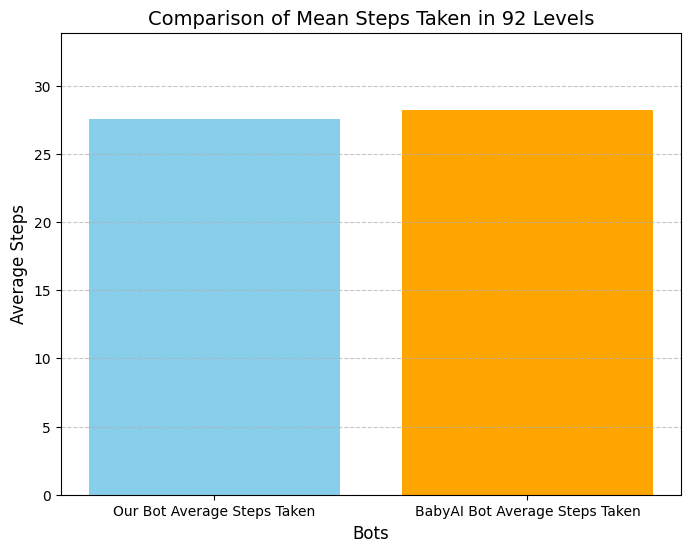

Our bot average step taken in 92 levels 28.824175824175825
BabyAI bot average step taken in 92 levels 28.22826086956522


In [50]:
import matplotlib.pyplot as plt

our_bot_balance_step=0
baby_ai_balance_step=0


if our_bot_completed_missions >= baby_completed_missions:
    for i, step in enumerate(baby_completed_missions_list):
        our_bot_balance_step += our_bot_reward_list[step]
        baby_ai_balance_step += baby_steps_for_level[step]

    values = [our_bot_balance_step / (i + 1), baby_ai_balance_step / (i + 1)]
else:
    for i, step in enumerate(our_bot_level_index):
        our_bot_balance_step += our_bot_reward_list[step]
        baby_ai_balance_step += baby_steps_for_level[step]

    values = [our_bot_balance_step / (i + 1), baby_ai_balance_step / (i + 1)]
# Data
labels = ["Our Bot Average Steps Taken", "BabyAI Bot Average Steps Taken"]

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=["skyblue", "orange"])
plt.title(f"Comparison of Mean Steps Taken in {i+1} Levels", fontsize=14)
    
plt.ylabel("Average Steps", fontsize=12)
plt.xlabel("Bots", fontsize=12)
plt.ylim(0, max(values) * 1.2)  # Adjust y-axis to add some padding
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

print(f"Our bot average step taken in {i+1} levels {our_bot_balance_step/i+1}")
print(f"BabyAI bot average step taken in {i+1} levels {baby_ai_balance_step / (i + 1)}")



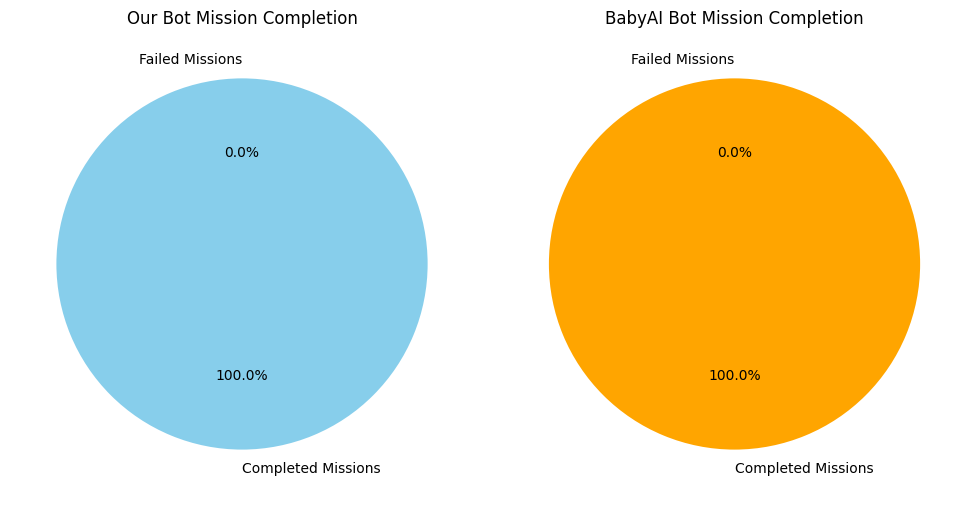

In [51]:

total_missions = 92

# Pie chart data for Our Bot
our_bot_pie_data = [our_bot_completed_missions, total_missions - our_bot_completed_missions]
our_bot_labels = ["Completed Missions", "Failed Missions"]

# Pie chart data for BabyAI Bot
babyai_pie_data = [baby_completed_missions, total_missions - baby_completed_missions]
babyai_labels = ["Completed Missions", "Failed Missions"]

# Plotting the pie chart for Our Bot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # Subplot for Our Bot
plt.pie(
    our_bot_pie_data, 
    labels=our_bot_labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=["skyblue", "lightgray"]
)
plt.title("Our Bot Mission Completion")

# Plotting the pie chart for BabyAI Bot
plt.subplot(1, 2, 2)  # Subplot for BabyAI Bot
plt.pie(
    babyai_pie_data, 
    labels=babyai_labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=["orange", "lightgray"]
)
plt.title("BabyAI Bot Mission Completion")

# Display the charts
plt.tight_layout()
plt.show()
